**This notebook is created to forecast the sales amount of a beverage company's product in Turkey. Due to secrecy reasons company only gives the data of how many liters are sold in a month and nothing else. Since we don't have much information about the data (Product name, exact regions that data is collected from, weather of these spesific regions, campaigns, etc.) we can't dig deeper into data and find usefull features by applying feature engineering. Therefore we have a Univariate Time Series which means there is only one variable that changes over time. Methods for forecasting Univariate time series are installed as default by many companies because they are not complex and they give decent results. We will be using 2 of the probably most popular methods to make a 12 periods(month) forecast on our data and compare their results with error measures.**

In [67]:
# Importing required libraries
import itertools
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from pandas import DataFrame
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing




### Downloading data and splitting Train and Test Data (48 months for Training, 12 Months for Test)

In [68]:
# There are 2 products named X and Y. We will forecast only the sales of product X.
df = pd.read_excel("XY_2013_2017.xlsx",parse_dates=True, index_col=1)
Total = df.iloc[:,1:2]
Total.drop(["Yıl-Ay"],inplace=True)
Total= Total.astype(float)
Total.columns=["Liters"]
Total.index=pd.to_datetime(Total.index)
Train=Total.iloc[:48,:]
Test=Total.iloc[48:,]
Train.tail()

,Liters
2016-08-01,264258.325476
2016-09-01,225043.250113
2016-10-01,188142.226595
2016-11-01,169803.632190
2016-12-01,168609.573785


### Basic Inspections on Data

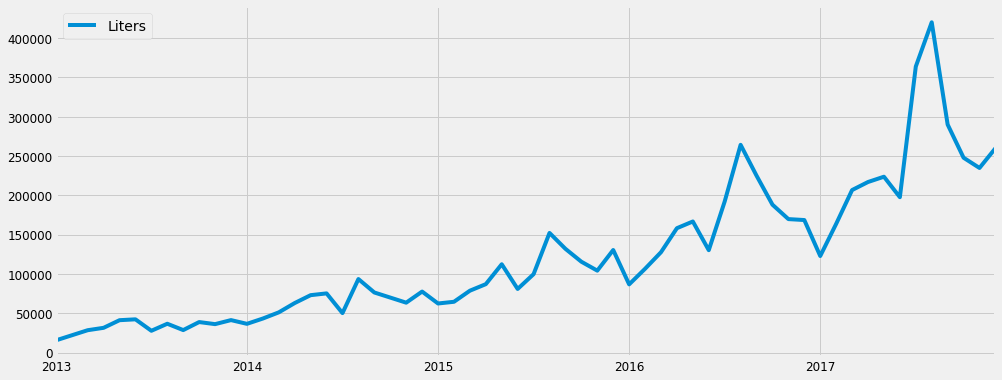

In [69]:
Total.plot(figsize=(15,6))
plt.show()

### Plot has sharp peaks especially at the last year, our time series is not stationary and it is multiplicative.

#### We will decompose data to its 3 components in order to understand the data better
##### – trend: how things are overall changing
##### – seasonality: how things change within a given period e.g. a year, month, week, day
##### – residual: activity not explained by the trend or the seasonal value

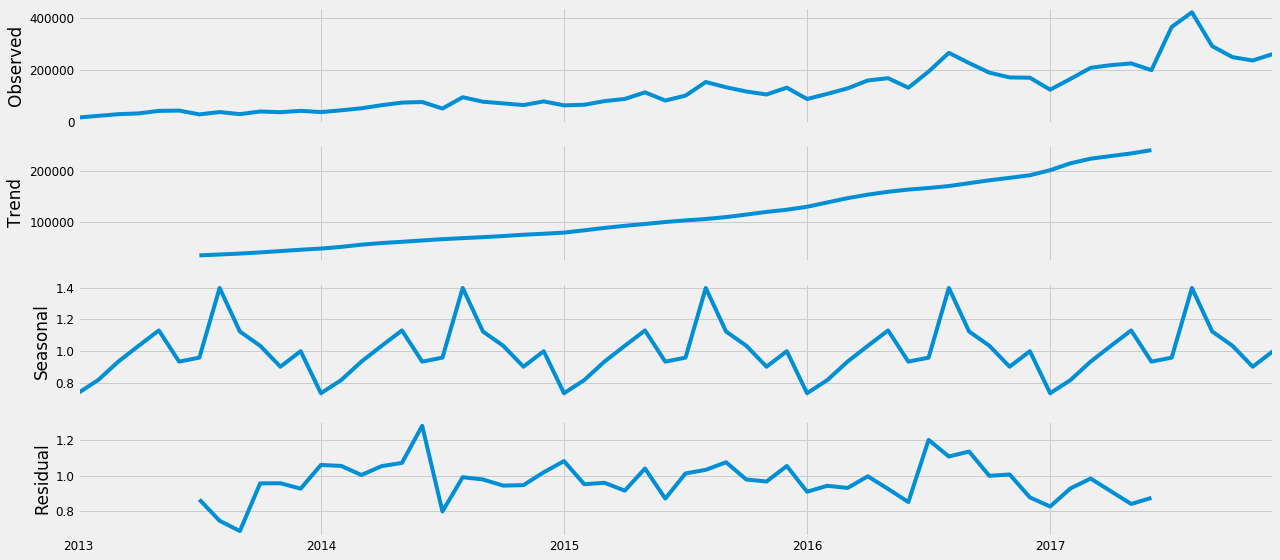

In [70]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(Total.iloc[:,0], model='multiplicative')
fig = decomposition.plot()
plt.show()

#### Yearly seasonality and a positive trend is observed. These are importand factors which decide whether a model is good for our data or not. Residuals are positively skewed but looks close to normally distributed which means most of the change in data is explained by trend and seasonality

Since data is not stationary, we have to apply a transformation method like log transform, square root, cube, etc. In this example we will apply Box-Cox Transformation to obtain a stationary time series which means the time series will have constant mean, constant variance and autocovariance does not depend on time. Most models assumes that the time series data is stationary and we have to ensure that for our data.

In [71]:
Bc_Train,fitted_lambda=stats.boxcox(Total)
print("Lambda Value is:  %f " %fitted_lambda)
Bc_Test = stats.boxcox(Test, fitted_lambda)

Lambda Value is:  0.122853 


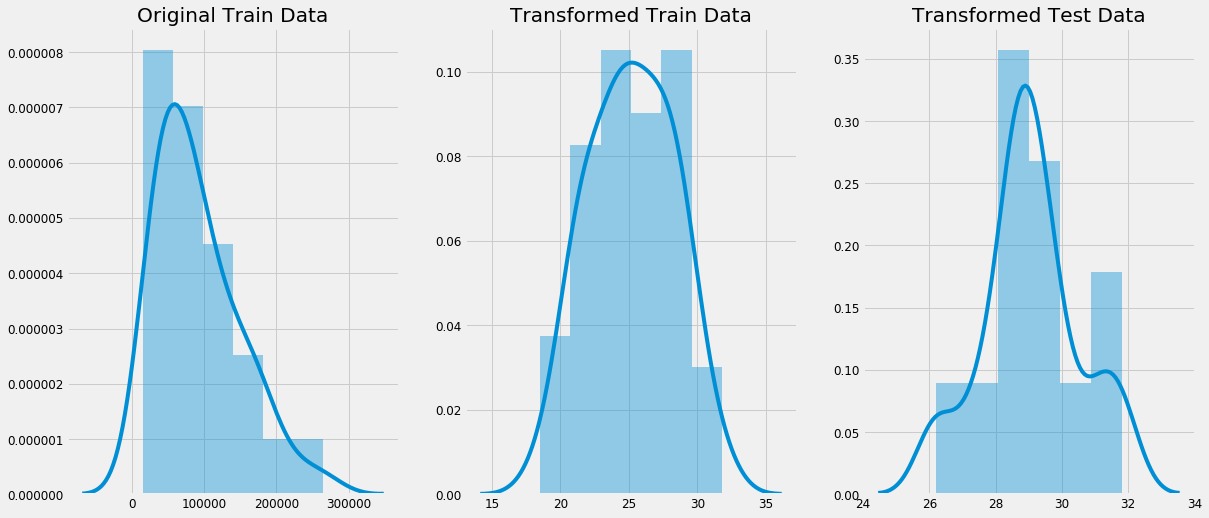

In [72]:
fig,ax =plt.subplots(1,3)
sns.distplot(Train, ax=ax[0]).set_title('Original Train Data')
sns.distplot(Bc_Train, ax=ax[1]).set_title('Transformed Train Data')
sns.distplot(Bc_Test, ax=ax[2]).set_title('Transformed Test Data')
plt.show()

##### One can observe that in the first plot, data was skewed to left, that could cause biased predictions, On the second and third plots, distribution is closer to normal distribution

# Forecasting with HOLT WİNTERS' SEASONAL METHOD (Exponantial Smoothing)

In [73]:
# defining a root mean squared error method to compare the success of different methods
def rmse(actual,forecast):
    rms = sqrt(mean_squared_error(actual, forecast))
    return rms

Code below is taken mostly taken https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html#Holt's-Winters-Seasonal which is statsmodels' website. I added a RMSE row to the results dataframe for future comparison purpose.

I didn't use transformed data because ExponantialSmoothing method already has a use_boxcox option which saves me from the burden of inverting the transformed values for method evaluation

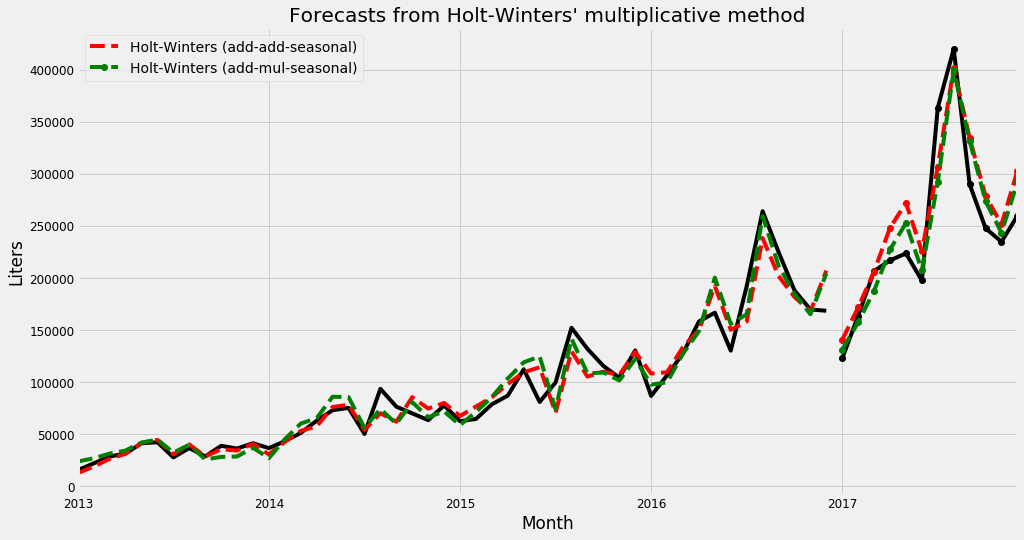

Figure 1: Forecasting Sales using Holt-Winters method with both additive and multiplicative seasonality.


,Additive,Mult. Seasonal,Multiplicative,Multiplica Dam
$\alpha$,3.157895e-01,3.157895e-01,3.157895e-01,3.157895e-01
$\beta$,4.038783e-02,5.259538e-02,5.259446e-02,5.259541e-02
$\phi$,NaN,NaN,NaN,9.993128e-01
$\gamma$,6.842105e-01,6.842105e-01,6.842105e-01,6.842105e-01
$l_0$,2.271384e+01,2.438346e+01,2.438332e+01,2.438346e+01
$b_0$,1.928540e-01,2.511457e-01,1.009586e+00,2.509733e-01
SSE,1.037360e+10,9.697921e+09,1.033918e+10,9.674117e+09
RMSE,3.306836e+04,2.965626e+04,3.603576e+04,2.937797e+04


In [74]:
warnings.filterwarnings("ignore")
fit1 = ExponentialSmoothing(Train["Liters"], seasonal_periods=12, trend='add', seasonal='add').fit(use_boxcox=True)
fit2 = ExponentialSmoothing(Train["Liters"], seasonal_periods=12, trend='add', seasonal='mul').fit(use_boxcox=True)
fit3 = ExponentialSmoothing(Train["Liters"], seasonal_periods=12, trend='mul', seasonal='mul').fit(use_boxcox=True)
fit4 = ExponentialSmoothing(Train["Liters"], seasonal_periods=12, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)

results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE","RMSE"])
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse] + [rmse(Test["Liters"],fit1.forecast(12))]
results["Mult. Seasonal"] = [fit2.params[p] for p in params] + [fit2.sse] + [rmse(Test["Liters"],fit2.forecast(12))]
results["Multiplicative"]   = [fit3.params[p] for p in params] + [fit3.sse] + [rmse(Test["Liters"],fit3.forecast(12))]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse] + [rmse(Test["Liters"],fit4.forecast(12))]
                                                                
ax = Test["Liters"].plot(figsize=(15,8), marker='o', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
ax.set_ylabel("Liters")
ax.set_xlabel("Month")
Train["Liters"].plot(ax=ax, color= "black")
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit2.fittedvalues.plot(ax=ax, style='--', color='green')

fit1.forecast(12).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)
fit2.forecast(12).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', marker='o', color='green', legend=True)

plt.show()
print("Figure 1: Forecasting Sales using Holt-Winters method with both additive and multiplicative seasonality.")

results                                                                

The final sum of squared errors achieved in optimizing(SSE) is lowest for multiplicative seasonality model as expected. Damping slightly helps but it is not a significant difference. You can see below that damping slop is almost 1. For forecasting windows that are longer then 1 year, damping could have helped more maybe

In [75]:
fit4.params

{'smoothing_level': 0.3157894736842105,
 'smoothing_slope': 0.05259540935641371,
 'smoothing_seasonal': 0.6842105263157894,
 'damping_slope': 0.9993127777718604,
 'initial_level': 24.383463103417327,
 'initial_slope': 0.25097327561298216,
 'initial_seasons': array([0.88867168, 0.92250824, 0.95190687, 0.96492696, 0.99745559,
        1.00217803, 0.94104736, 0.97876001, 0.90214999, 0.90499056,
        0.88363152, 0.90544584]),
 'use_boxcox': True,
 'lamda': 0.13819884845281916,
 'remove_bias': False}

# FORECASTING WITH SARIMA

ARIMA method has 3 components named AR(p) I(d) MA(q). One should investigate ACF and PACF plots to determine these parameters and try a few of the models in order to find the best one by comparing their AİC scores. You can take a look at https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/ website to understand how the ARIMA methodology works and what does these parametes mean. In this notebook, we will not dive into these and instead will use the code below to loop through some parameter combinations of models and do parameter optimization in order to find the best model. The code below is derived from https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/ website where we can understand how to make grid search on python for ARIMA hyperparameters.

In [76]:
def find_best_sarima(train, eval_metric):
    
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    counter = 0
    myDict = {}
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                counter += 1
                mod = sm.tsa.statespace.SARIMAX(train,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                myDict[counter] = [results.aic, results.bic, param, param_seasonal]

            except:
                continue
                
    dict_to_df = pd.DataFrame.from_dict(myDict,orient='index')
    
    if eval_metric == 'aic':
        best_run = dict_to_df[dict_to_df[0] == dict_to_df[0].min()].index.values
        best_run = best_run[0]
    elif eval_metric == 'bic':
        best_run = dict_to_df[dict_to_df[1] == dict_to_df[1].min()].index.values
        best_run = best_run[0]
            
    model = sm.tsa.statespace.SARIMAX(train,
                                      order=myDict[best_run][2],
                                      seasonal_order=myDict[best_run][3],
                                      enforce_stationarity=False,
                                      enforce_invertibility=False).fit()
    
    best_model = {'model':model, 
                  'aic':model.aic,
                  'bic':model.bic,
                  'order':myDict[best_run][2], 
                  'seasonal_order':myDict[best_run][3]}
    
    return best_model

In [77]:
best = find_best_sarima(Bc_Train, 'aic')
print("Best SARIMA Model for our data is: {}x{} with aic= {} and bic= {}".format(best["order"], best["seasonal_order"], best["aic"], best["bic"]))
best

Best SARIMA Model for our data is: (1, 1, 1)x(1, 1, 0, 12) with aic= 64.6912129036418 and bic= 70.79665500210645


{'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0xd3f63d0>,
 'aic': 64.6912129036418,
 'bic': 70.79665500210645,
 'order': (1, 1, 1),
 'seasonal_order': (1, 1, 0, 12)}

<font color=red > find_best_arima</font> method found the best SARIMA model as <font color=blue > SARIMA(111X110)_12 </font> according to akaike information criterion(aic). We can do further investigation on the resudiuls of the data to confirm that our model is not missing out any meaningfull information.

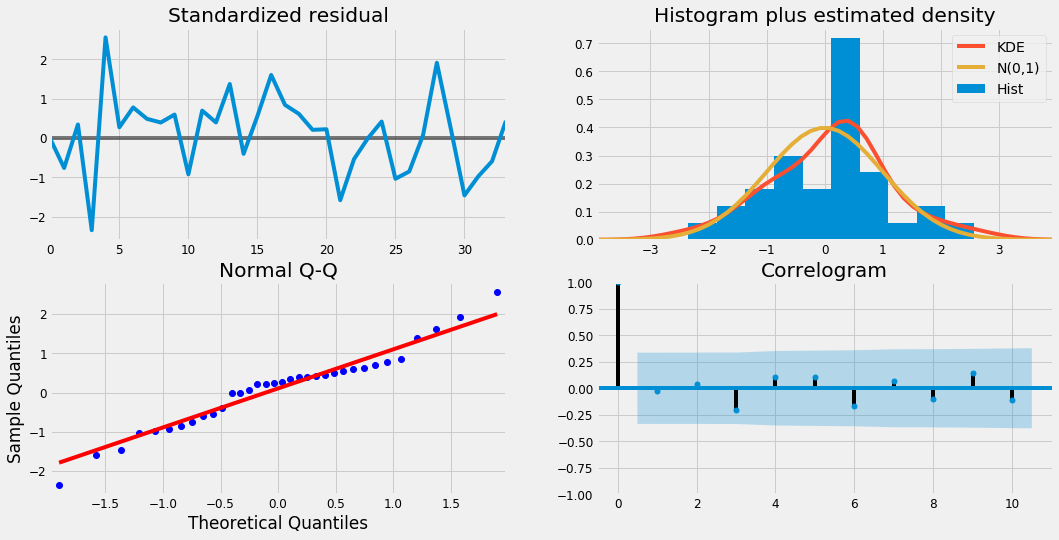

In [78]:
mod = sm.tsa.statespace.SARIMAX(Bc_Train,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
results.plot_diagnostics(figsize=(16, 8))
plt.show()

##### Top-Left: _Residuals are distribution looks random as expeckted._
##### Top-Right: _Kernel Density Estimate(KDE) curve is close to normal curve although it doesn't fit perfectly as in many practical cases._
##### Bottom-Left: _Sample quantiles(blue dots) are aligning well with the normal distribution quantiles(red line). This means again residuals are almost normally_ _distributed._
##### Bottom-Right: _Correlogram is another name for autocorrelation function. We can see the instant drop from the first period. This Autocorrelation plot shows that there_ _is no relation between the residual observations on any time lag._

### Now we are convinced that our model is good. It is time to plot our results and calculate the error.

##### Predictions of the model is below. We have to invert the box-cox transformed values to their original scales before anything.

In [79]:
pred = best['model'].predict(start=48, end=59, dynamic=True)
pred

array([26.49822988, 27.49661807, 28.26429244, 29.23029525, 29.39247899,
       28.34960043, 30.11197487, 31.53149965, 30.78388245, 29.95870896,
       29.50371206, 29.39316621])

In [80]:
# invert a boxcox transform for one value
def power_transform_invert_value(value, lam):
	from math import log
	from math import exp
	# log case
	if lam == 0:
		return exp(value)
	# all other cases
	return exp(log(lam * value + 1) / lam)

In [81]:
# Invert all the predicted values
o_pred=[]
for prediction in pred:
    o_pred.append(power_transform_invert_value(prediction,fitted_lambda))
pred=pd.DataFrame(o_pred,index=Test.index, columns=["Liters"])    
pred

,Liters
2017-01-01,131659.181751
2017-02-01,165921.864959
2017-03-01,197354.564675
2017-04-01,244247.160856
2017-05-01,253010.385531
2017-06-01,201150.659984
2017-07-01,295300.842999
2017-08-01,397261.165320
2017-09-01,340267.707793
2017-10-01,285806.426552


##### Values above are the precition from our SARIMA model. Now lets see it on a plot.

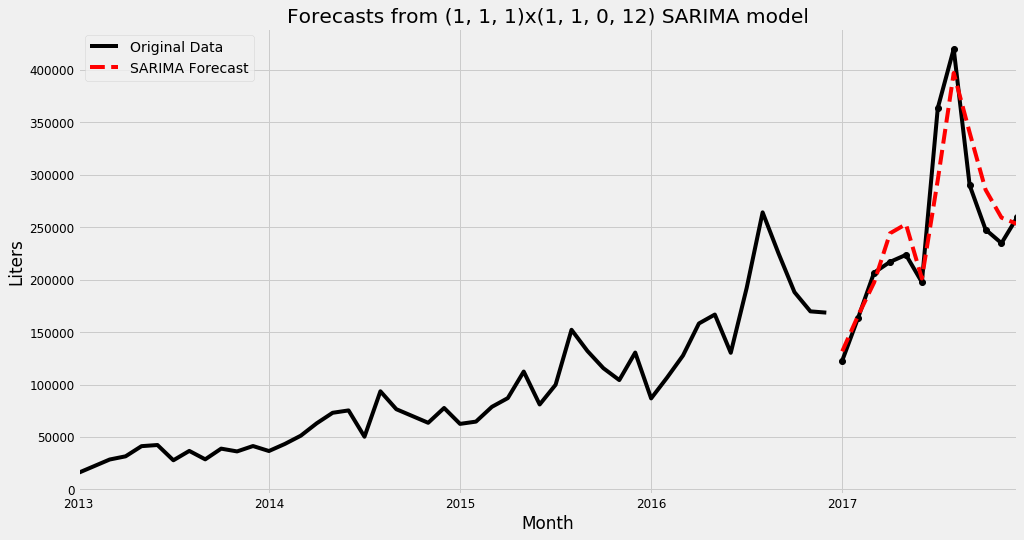

In [82]:
ax = Test["Liters"].rename("Original Data").plot(figsize=(15,8), marker='o', color='black', title="Forecasts from (1, 1, 1)x(1, 1, 0, 12) SARIMA model",legend=True)
ax.set_ylabel("Liters")
ax.set_xlabel("Month")
Train["Liters"].plot(ax=ax, color= "black")
pred["Liters"].rename("SARIMA Forecast").plot(ax=ax, style='--', color='red', legend=True)





plt.show()



In [83]:
print('The Root Mean Squared Error of our forecasts is {}'.format(rmse(Test["Liters"],pred["Liters"])))

The Root Mean Squared Error of our forecasts is 31095.3859847261


#### We come to the conclution that Holt Winters' Seasonal method gave a slightly better result when compared with the RMSE.
When doing forecasting, it is usually a good practice to try forecasting in different windows* and compare the errors. For a forecasting of 12 months, Holt Winters' method worked a little better but perhaps if we did a 6 months long forecasting, SARIMA could yield a better result. Therefore it is important to check in different windows.

### This is the end of our notebook